In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Loading


In [12]:
# emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_uk_df = pd.read_csv('D:/Documents/emofilm/data/emofilm_uk_df.csv')
emofilm_df = pd.read_csv('D:/Documents/emofilm_df.csv')
ravdess_df = pd.read_csv('D:/Documents/ravdess_df.csv')
cremad_df = pd.read_csv('D:/Documents/cremad_df.csv')

In [13]:
data_df = pd.concat([emofilm_df, emofilm_uk_df, ravdess_df, cremad_df],
                    axis=0, ignore_index=True)

data_df_no_uk = pd.concat([emofilm_df, ravdess_df, cremad_df],
                          axis=0, ignore_index=True)

In [14]:
data_df_no_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  9997 non-null   object
 1   path     9997 non-null   object
dtypes: object(2)
memory usage: 156.3+ KB


In [15]:
emotions = data_df.emotion.unique().tolist()
emotions_number = len(emotions)
print(emotions, emotions_number)

['fear', 'contempt', 'happiness', 'anger', 'sadness', 'neutral', 'calm', 'surprise'] 8


In [39]:
def load_features(path, shape):
    df = pd.read_csv(path)
    print(df.info())

    labels = df['labels']
    features = df.drop(columns=['labels']).to_numpy()
    features = features.reshape(shape)
    return [features, labels]

In [47]:
train_features_e, train_labels_decoded = load_features(
    './features/features-2d-train-v1.csv', (20991, 140, 130, 1))
test_features_e, test_labels_decoded = load_features(
    './features/features-2d-test-v1.csv', (900, 140, 130, 1))
val_features_e, val_labels_decoded = load_features(
    './features/features-2d-val-v1.csv', (2100, 140, 130, 1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20991 entries, 0 to 20990
Columns: 18201 entries, 0 to labels
dtypes: float64(18200), object(1)
memory usage: 2.8+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 18201 entries, 0 to labels
dtypes: float64(18200), object(1)
memory usage: 125.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Columns: 18201 entries, 0 to labels
dtypes: float64(18200), object(1)
memory usage: 291.6+ MB
None


In [48]:
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(
    np.array(train_labels_decoded).reshape(-1, 1)).toarray()
test_labels = encoder.fit_transform(
    np.array(test_labels_decoded).reshape(-1, 1)).toarray()
val_labels = encoder.fit_transform(
    np.array(val_labels_decoded).reshape(-1, 1)).toarray()

## Data Preparation


In [174]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def invert_polarity(data):
    return data * -1


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

feature extraction functions


In [175]:
def extract_zcr(data):
    return librosa.feature.zero_crossing_rate(y=data)


def extract_chroma_stft(data, sr):
    return librosa.feature.chroma_stft(y=data, sr=sr)


def extract_mfcc(data, sr):
    return librosa.feature.mfcc(y=data, sr=sr)


def extract_rms(data):
    return librosa.feature.rms(y=data)


def extract_melspectrogram(data, sr):
    return librosa.feature.melspectrogram(y=data, sr=sr, n_fft=512)

In [176]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
import math
from numpy import ndarray


def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


def fix_length(data: ndarray, length: int):
    fixed = data.reshape(len(data), 1)
    fixed = padding(fixed, length, 1)
    fixed = fixed.reshape(len(fixed))

    return fixed


def repeat_audio(data: ndarray, sr: int, duration_millis: int):

    length = int(duration_millis/1000*sr)
    n = math.ceil(duration_millis/1000*sr/len(data))
    fixed = np.tile(data, n)
    fixed = fixed[:length]

    return fixed

In [177]:
max_length = 110250
max_i = 14
sample_rate = 22050
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 216  # 5 seconds of adio is 216
height = 128  # melspectrogram height is 128

duration = int(required_duration_millis/1000*sample_rate)

width_3s = int(3*sample_rate)

In [178]:
a, sr = librosa.load(data_df['path'][2])
print(a.shape, sr)

(54860,) 22050


In [179]:
a_fixed = librosa.util.fix_length(a, size=width_3s)
print(a_fixed.shape, sr)
Audio(data=a_fixed, rate=sr)

(66150,) 22050


In [180]:
width2 = int(required_duration_millis/1000*sr)
width2

110250

In [181]:
repeated_audio = repeat_audio(a, sample_rate, required_duration_millis)

print('Array length before padding', np.shape(a))
print('Audio length before padding in seconds', (np.shape(a)[0]/sr))
print('Array length after padding', np.shape(repeated_audio))
print('Audio length after padding in seconds',
      (np.shape(repeated_audio)[0]/sr))
Audio(data=repeated_audio, rate=sr)

Array length before padding (54860,)
Audio length before padding in seconds 2.487981859410431
Array length after padding (110250,)
Audio length after padding in seconds 5.0


(20, 108)


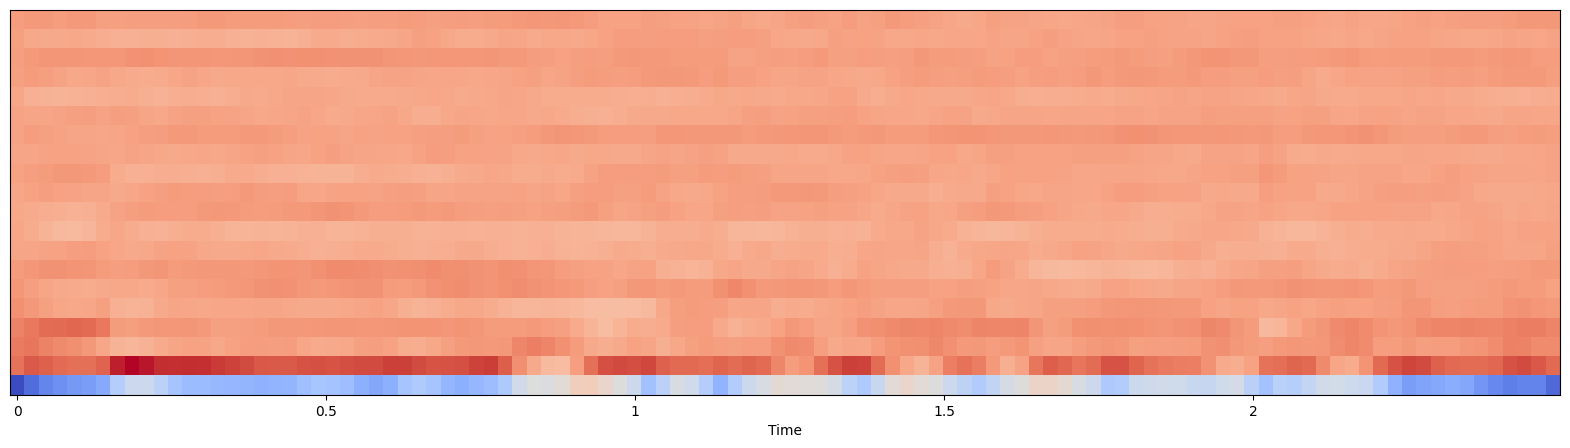

In [182]:
# MFCC
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(y=a, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

(12, 108)


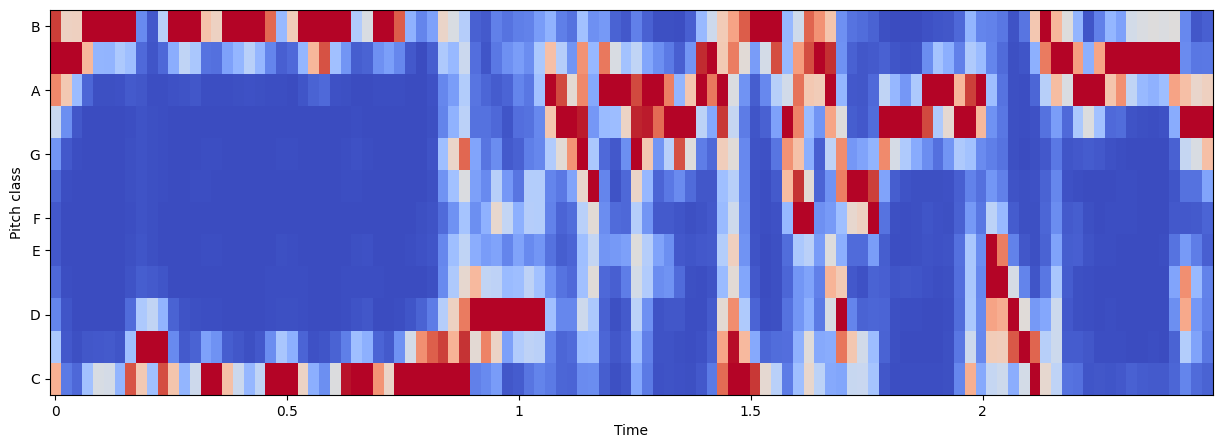

In [183]:
hop_length = 512
S = np.abs(librosa.stft(a))
chromagram = librosa.feature.chroma_stft(
    y=a, sr=sr, hop_length=hop_length)
print(chromagram.shape)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time',
                         y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

(128, 108)


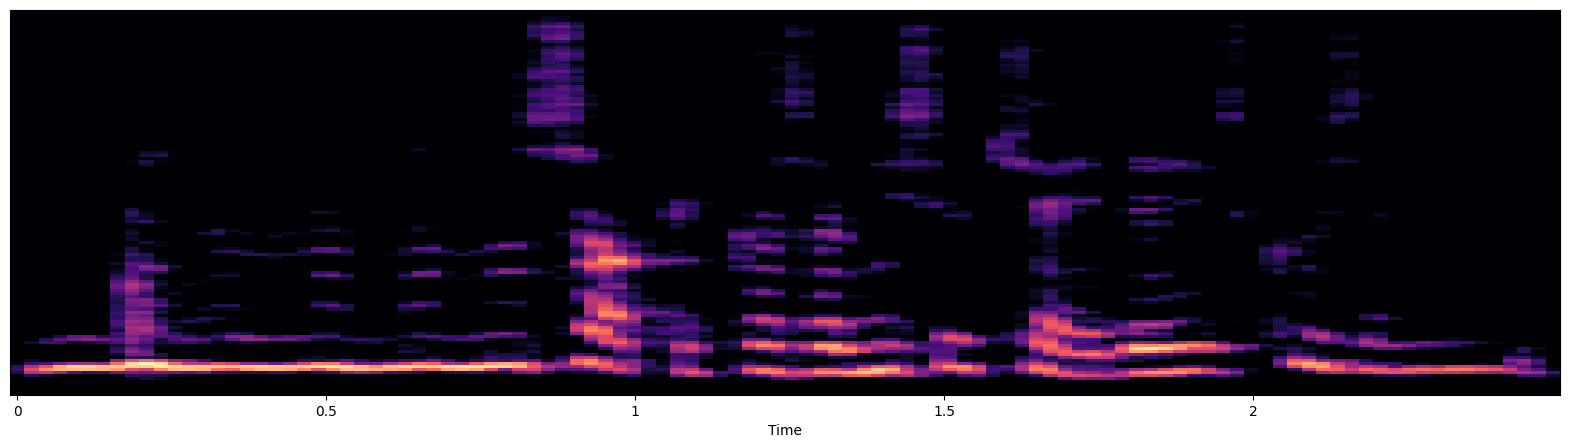

In [184]:
mel_scale_sgram = librosa.feature.melspectrogram(y=a, sr=sr)
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
print(mel_sgram.shape)

plt.figure(figsize=(20, 5))
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time')

(128, 108)


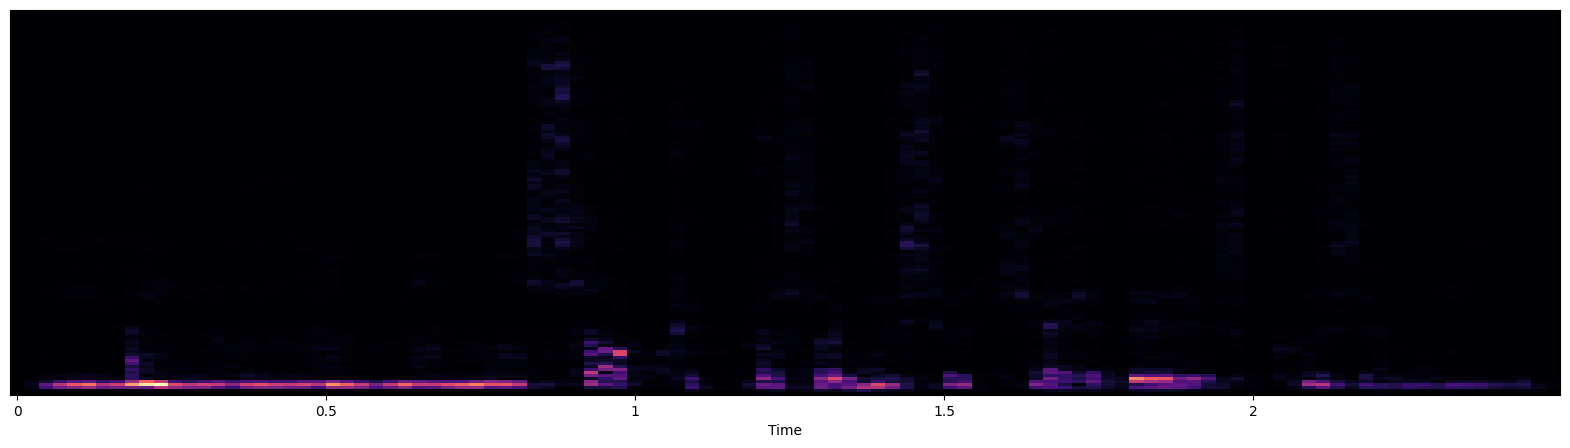

In [185]:
stft = librosa.stft(a, n_fft=255, hop_length=512)
print(stft.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(stft, sr=sr, x_axis='time')

(160, 108)


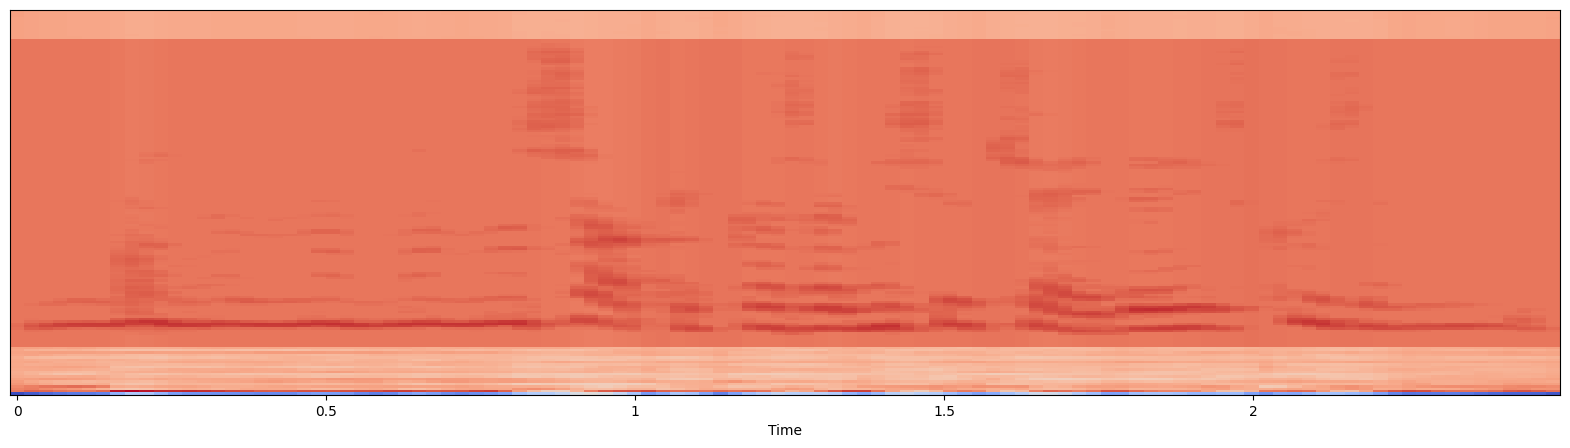

In [186]:
from sklearn import preprocessing
img = np.vstack((mfccs, mel_sgram, chromagram))
scaler = preprocessing.StandardScaler().fit(img)
img_scaled = scaler.transform(img)
print(img_scaled.shape)

plt.figure(figsize=(20, 5))
librosa.display.specshow(img_scaled, sr=sr, x_axis='time')

In [187]:
print(mfccs.shape, chromagram.shape)

(20, 108) (12, 108)


In [188]:
def generate_features_v2(data, sr, max_width: int):
    data = librosa.util.fix_length(data, size=max_width)
    mel_scale_sgram = librosa.feature.melspectrogram(y=data, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

    chromagram = librosa.feature.chroma_stft(
        y=data, sr=sr, hop_length=hop_length)

    image = np.vstack((mel_sgram, chromagram))

    return image

In [189]:
def generate_features(y_cut):
    max_size = 200  # my max audio file feature width
    stft = padding(
        np.abs(librosa.stft(y_cut, n_fft=255, hop_length=512)), 128, max_size)

    MFCCs = padding(librosa.feature.mfcc(y=y_cut,
                    hop_length=hop_length, n_mfcc=128), 128, max_size)

    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)

    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)

    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)

    # Now the padding part
    image = np.array([padding(normalize(spec_bw), 1, max_size)]
                     ).reshape(1, max_size)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, max_size), axis=0)
    # repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized

    for i in range(0, 9):
        image = np.append(image, padding(
            normalize(spec_bw), 1, max_size), axis=0)

        image = np.append(image, padding(
            normalize(spec_centroid), 1, max_size), axis=0)

        image = np.append(image, padding(
            normalize(chroma_stft), 12, max_size), axis=0)

    image = np.dstack((image, np.abs(stft)))
    image = np.dstack((image, MFCCs))

    return image


def generate_features_spectrogram(data):

    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr)

    spec_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)

    chroma_stft = librosa.feature.chroma_stft(y=data, sr=sr)

    zcr = extract_zcr(data=data)

    rms = extract_rms(data=data)

    stft = np.abs(librosa.stft(data, n_fft=255, hop_length=512))
    MFCCs = librosa.feature.mfcc(
        y=data, hop_length=hop_length, n_mfcc=height)

    mels = extract_melspectrogram(data=data, sr=sr)

    image = generate_image(spec_bw, spec_centroid, zcr,
                           rms, chroma_stft, stft, MFCCs)

    return image


def generate_image(spec_bw, spec_centroid, zcr, rms, chroma_stft, stft, MFCCs, img_height=128, use_normalize=True):

    image_width = spec_bw.shape[1]

    image = np.zeros((0, image_width))

    for i in range(0, 8):
        image = np.append(image, padding(
            normalize(spec_bw), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(spec_centroid), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(zcr), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(rms), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(chroma_stft), 12, image_width), axis=0)

    if (image.shape[0] != img_height or stft.shape[0] != img_height or MFCCs.shape[0] != img_height):
        print(
            f'Incorrect sizes\nimage.shape={image.shape}\tstft.shape={stft.shape}\tMFCCs.shape={MFCCs.shape}')

        return image

    if (use_normalize):
        stft = padding(



            normalize(stft), img_height, image_width)

        MFCCs = padding(



            normalize(MFCCs), img_height, image_width)

    image = np.dstack((image, stft))

    image = np.dstack((image, MFCCs))

    return image

In [190]:
# image2 = generate_features_spectrogram(repeated_audio)
# print(image2.shape)
# plt.imshow(image2)

## Feature extraction


get features from all files


In [36]:
data_df.head(1)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [192]:
from pandas import DataFrame

duration = int(required_duration_millis/1000*sample_rate)


def get_features_v2(data: DataFrame, augment=True):
    features = []
    labels = []

    for i, row in data.iterrows():
        audio, sr = librosa.load(row['path'])
        image = generate_features_v2(audio, sr, width_3s)
        features.append(image[np.newaxis, ...])
        labels.append(row['emotion'])
        if augment:
            noise_audio = noise(audio)
            image = generate_features_v2(noise_audio, sr, width_3s)
            features.append(image[np.newaxis, ...])
            labels.append(row['emotion'])

            inverse_polarity_audio = invert_polarity(audio)
            image = generate_features_v2(inverse_polarity_audio, sr, width_3s)
            features.append(image[np.newaxis, ...])
            labels.append(row['emotion'])

    result = np.concatenate(features, axis=0)
    return (np.array(result), labels)


def get_melspectrogram(data: DataFrame, augment=True):
    features = []
    labels = []

    for i, row in data.iterrows():
        # load audio
        audio, sr = librosa.load(row['path'])
        # audio = fix_length(audio, duration)
        audio = repeat_audio(audio, sr, 5000)
        # get spectrogram
        image = librosa.feature.melspectrogram(y=repeated_audio, sr=sr)
        # add to features
        features.append(image[np.newaxis, ...])
        # add label
        labels.append(row['emotion'])
        if augment:
            noise_audio = noise(audio)
            image = librosa.feature.melspectrogram(y=noise_audio, sr=sr)
            features.append(image[np.newaxis, ...])
            labels.append(row['emotion'])

            inverse_polarity_audio = invert_polarity(audio)
            image = librosa.feature.melspectrogram(
                y=inverse_polarity_audio, sr=sr)
            features.append(image[np.newaxis, ...])
            labels.append(row['emotion'])

    # return result
    result = np.concatenate(features, axis=0)
    return (np.array(result), labels)


def get_features(data: DataFrame, augment=True):
    features = []
    labels = []

    for i, row in data.iterrows():
        # load audio
        audio, sr = librosa.load(row['path'])
        # audio = fix_length(audio, duration)
        audio = repeat_audio(audio, sr, 5000)
        # get spectrogram
        image = generate_features_spectrogram(audio)
        # add to features
        features.append(image[np.newaxis, ...])
        # add label
        labels.append(row['emotion'])
        if augment:
            noise_audio = noise(audio)
            image = generate_features_spectrogram(noise_audio)
            features.append(image[np.newaxis, ...])
            labels.append(row['emotion'])

            inverse_polarity_audio = noise(audio)
            image = generate_features_spectrogram(inverse_polarity_audio)
            features.append(image[np.newaxis, ...])
            labels.append(row['emotion'])

    # return result
    result = np.concatenate(features, axis=0)
    return (np.array(result), labels)

In [37]:
X = data_df_no_uk['path']
y = data_df_no_uk['emotion']

In [38]:
y

0            fear
1            fear
2            fear
3            fear
4            fear
          ...    
9992     contempt
9993         fear
9994    happiness
9995      neutral
9996      sadness
Name: emotion, Length: 9997, dtype: object

In [195]:
# encoder = OneHotEncoder()
# y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.3, random_state=42)
# print(X_train.shape, X_val.shape)

# X_val, X_test, y_val, y_test = train_test_split(
#     X_val, y_val, test_size=0.3, random_state=42)
# print(X_val.shape, X_test.shape)

In [198]:
print(f'train: {X_train.shape}\ntest: {X_test.shape}\nval: {X_val.shape}')

train: (6997,)
test: (900,)
val: (2100,)


In [199]:
# train_df = pd.DataFrame(list(zip(y_train, X_train)),
#                         columns=['emotion', 'path'])
# test_df = pd.DataFrame(list(zip(y_test, X_test)), columns=['emotion', 'path'])
# val_df = pd.DataFrame(list(zip(y_val, X_val)), columns=['emotion', 'path'])

In [231]:
# train_features, train_labels = get_features_v2(train_df, augment=True)
# test_features, test_labels = get_features_v2(test_df, augment=False)
# val_features, val_labels = get_features_v2(val_df, augment=False)

# train_labels = np.vstack(train_labels)
# test_labels = np.vstack(test_labels)
# val_labels = np.vstack(val_labels)

# train_labels_decoded = encoder.inverse_transform(train_labels).squeeze()
# test_labels_decoded = encoder.inverse_transform(test_labels).squeeze()
# val_labels_decoded = encoder.inverse_transform(val_labels).squeeze()

In [233]:
# train_labels_decoded = encoder.inverse_transform(train_labels).squeeze()
# test_labels_decoded = encoder.inverse_transform(test_labels).squeeze()
# val_labels_decoded = encoder.inverse_transform(val_labels).squeeze()

scale data


In [ ]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# print(
#     f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

In [ ]:
print(f'train: {train_features.shape, len(train_labels)}\ntest: {test_features.shape, len(test_labels)}\nval: {val_features.shape, len(val_labels)}')

train: ((20991, 140, 130), 20991)
test: ((900, 140, 130), 900)
val: ((2100, 140, 130), 2100)


In [234]:
# train_features_e = np.expand_dims(train_features, axis=3)
# test_features_e = np.expand_dims(test_features, axis=3)
# val_features_e = np.expand_dims(val_features, axis=3)
# print(f'train: {train_features_e.shape, len(train_labels)}\ntest: {test_features_e.shape, len(test_labels)}\nval: {val_features_e.shape, len(val_labels)}')

train: ((20991, 140, 130, 1), 20991)
test: ((900, 140, 130, 1), 900)
val: ((2100, 140, 130, 1), 2100)


In [ ]:
# print(val_features_e.shape)
# arr_r = val_features_e.reshape(len(val_features_e), -1)
# print(arr_r.shape)

# arr_r2 = arr_r.reshape(len(arr_r), 140, 130, 1)
# print(arr_r2.shape)

# print(np.array_equal(val_features_e, arr_r2))

(2100, 140, 130, 1)
(2100, 18200)
(2100, 140, 130, 1)
True


In [4]:
def save_features(features, labels, path):
    sample_shape = features.shape
    arr = features.reshape(len(features), -1)
    df = pd.DataFrame(arr)
    df['labels'] = labels

    df.to_csv(path, index=False)
    print(df.info())
    return sample_shape

In [235]:
# train_shape = save_features(
#     train_features_e, train_labels_decoded, './features/features-2d-train-v1.csv')
# test_shape = save_features(
#     test_features_e, test_labels_decoded, './features/features-2d-test-v1.csv')
# val_shape = save_features(
#     val_features_e, val_labels_decoded, './features/features-2d-val-v1.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20991 entries, 0 to 20990
Columns: 18201 entries, 0 to labels
dtypes: float64(18200), object(1)
memory usage: 2.8+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 18201 entries, 0 to labels
dtypes: float32(18200), object(1)
memory usage: 62.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Columns: 18201 entries, 0 to labels
dtypes: float32(18200), object(1)
memory usage: 145.8+ MB
None


In [219]:
train_features_e, train_labels_decoded = load_features(
    './features/features-2d-train-v1.csv', (20991, 140, 130, 1))
test_features_e, test_features_decoded = load_features(
    './features/features-2d-test-v1.csv', (900, 140, 130, 1))
val_features_e, val_features_decoded = load_features(
    './features/features-2d-val-v1.csv', (2100, 140, 130, 1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Columns: 18201 entries, 0 to labels
dtypes: float64(18200), object(1)
memory usage: 291.6+ MB
None


In [228]:
val_features_e.shape

(2100, 140, 130, 1)

In [229]:
val_features_r.shape

(2100, 140, 130, 1)

In [230]:
print(np.allclose(val_features_r, val_features_e))

True


In [ ]:
for i in val_shape:
    print(i)

140
130
1


## Modeling


In [49]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### main


In [50]:
train_features_e[0].shape

(140, 130, 1)

In [51]:
input_shape = train_features_e[0].shape
CNNmodel = Sequential()
CNNmodel.add(Conv2D(32, 7, activation='relu',
             input_shape=input_shape, padding='same'))
CNNmodel.add(MaxPooling2D(2))
CNNmodel.add(Conv2D(32, 3, activation='relu', padding='same'))
CNNmodel.add(MaxPooling2D(2))
CNNmodel.add(Conv2D(64, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(64, 3, activation='relu', padding='same'))
CNNmodel.add(Dropout(0.3))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Conv2D(256, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(256, 3, activation='relu', padding='same'))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Flatten())
CNNmodel.add(Dropout(0.3))
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dense(units=emotions_number, activation='softmax'))

In [52]:
CNNmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy', metrics=['accuracy'])

CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 140, 130, 32)      1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 70, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 65, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 32, 64)        3

 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)         590080    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
          

In [54]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)

history = CNNmodel.fit(train_features_e, train_labels, batch_size=16,
                       epochs=10,
                       validation_data=(val_features_e, val_labels),
                       callbacks=[rlrp])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

8/8 [==============================] - 0s 22ms/step - loss: 2.4038 - accuracy: 0.4416
Accuracy of our model on test data :  44.155845046043396 %


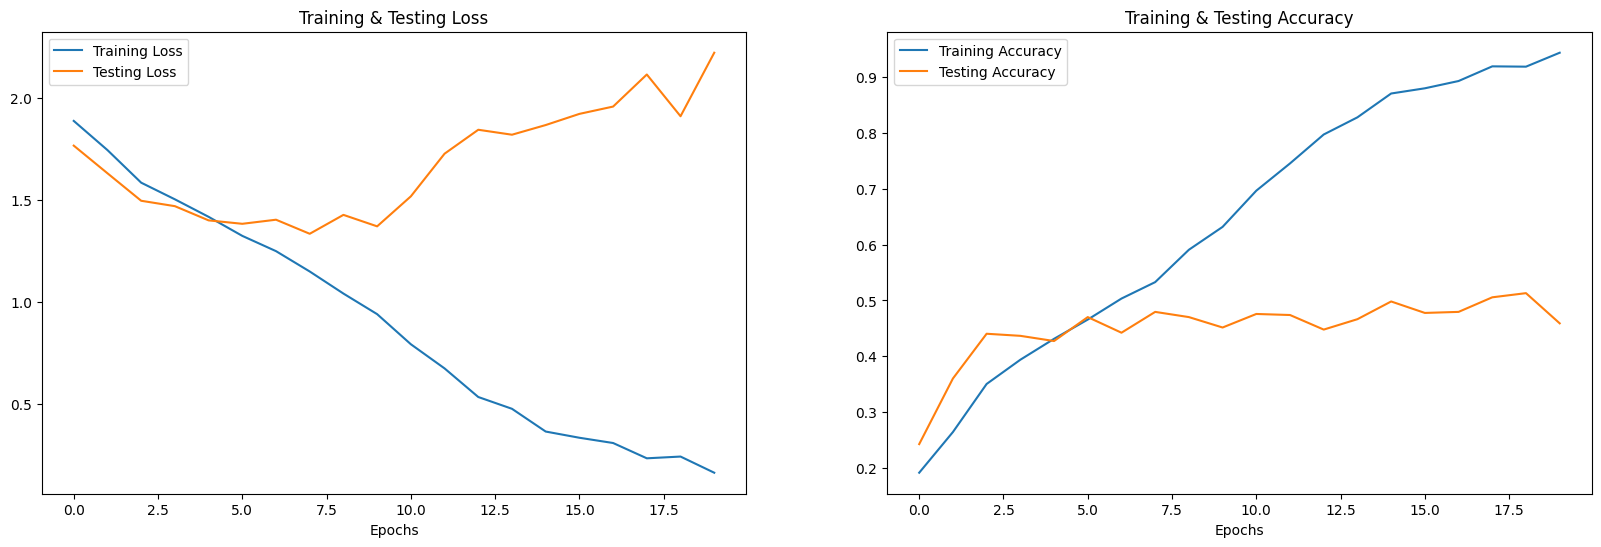

In [ ]:
print_report(CNNmodel, history, test_features_e, test_labels)

In [ ]:
# predicting on test data.
y_pred = CNNmodel.predict(test_features_e)

y_pred_decoded = encoder.inverse_transform(y_pred)
# y_test_decoded = encoder.inverse_transform(test_labels)

8/8 [==============================] - 0s 19ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_decoded.flatten()
df['Actual Labels'] = test_labels_decoded.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,contempt
1,contempt,fear
2,anger,anger
3,calm,contempt
4,fear,anger
5,sadness,sadness
6,sadness,anger
7,anger,anger
8,anger,happiness
9,fear,happiness


In [ ]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

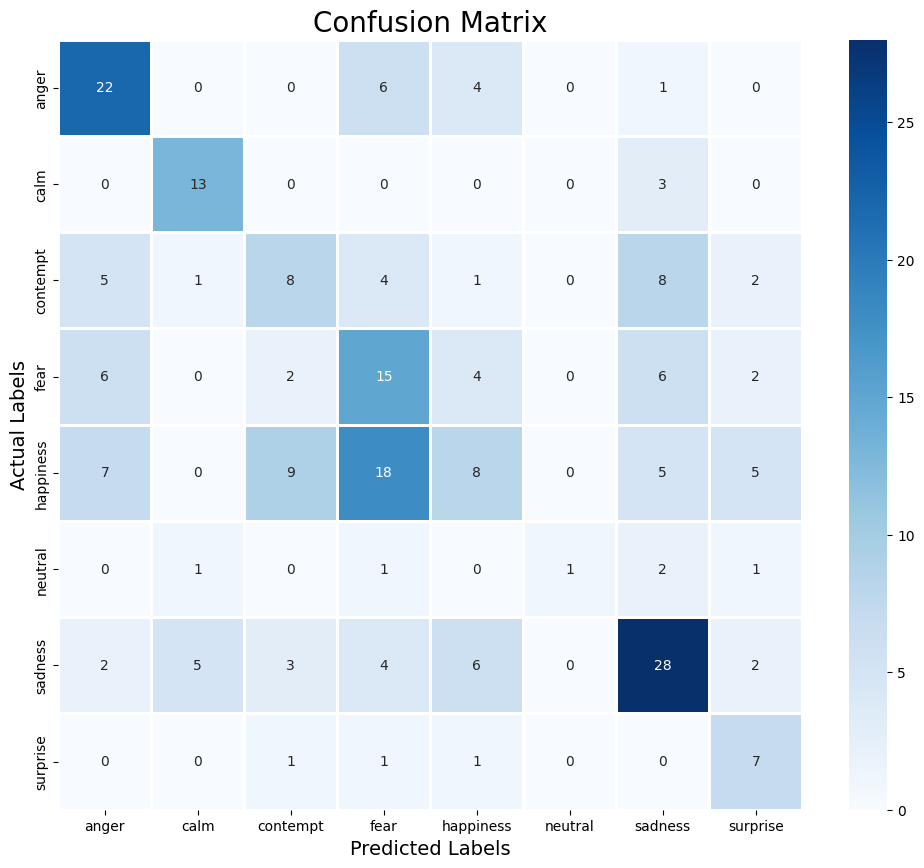

In [ ]:
print_confusion_matrix(test_labels_decoded, y_pred_decoded)

In [ ]:
print(classification_report(test_labels_decoded, y_pred_decoded))

              precision    recall  f1-score   support

       anger       0.52      0.67      0.59        33
        calm       0.65      0.81      0.72        16
    contempt       0.35      0.28      0.31        29
        fear       0.31      0.43      0.36        35
   happiness       0.33      0.15      0.21        52
     neutral       1.00      0.17      0.29         6
     sadness       0.53      0.56      0.54        50
    surprise       0.37      0.70      0.48        10

    accuracy                           0.44       231
   macro avg       0.51      0.47      0.44       231
weighted avg       0.44      0.44      0.42       231

